# Analysis of loop sequences using custom embedding

In this notebook I analyze features of chromatin loops vs non-loops sequences using custom wor2vec embedding vectors trained on the yeast genome.

In [1]:
import pickle
import yaml
import tqdm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    LeaveOneOut
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from seqloops.config import features

In [2]:
loops = pickle.load(open(features, 'rb'))

In [3]:
loops.columns

Index(['chrom', 'start', 'end', 'status', 'h3k18ac', 'h4k20me', 'h3k4me',
       'scc1pk9', 'h3k79me', 'h4r3me2s', 'h3k36me2', 'h4k16ac', 'h4k12ac',
       'h3k27ac', 'h2ak5ac', 'h3k4me3', 'h4k8ac', 'h3k9ac', 'h3k36me3',
       'h3k56ac', 'h4k5ac', 'h3k4me2', 'h3k36me', 'h3k14ac', 'h3s10ph',
       'h3k79me3', 'h3k4ac', 'h4r3me', 'htz1', 'h3k23ac', 'h2as129ph', 'seq',
       'embedding', 'GC', 'GC_bias', 'entropy'],
      dtype='object')

In [4]:
histones = loops.filter(regex='^h[234].*').applymap(np.mean)
histones.columns

Index(['h3k18ac', 'h4k20me', 'h3k4me', 'h3k79me', 'h4r3me2s', 'h3k36me2',
       'h4k16ac', 'h4k12ac', 'h3k27ac', 'h2ak5ac', 'h3k4me3', 'h4k8ac',
       'h3k9ac', 'h3k36me3', 'h3k56ac', 'h4k5ac', 'h3k4me2', 'h3k36me',
       'h3k14ac', 'h3s10ph', 'h3k79me3', 'h3k4ac', 'h4r3me', 'h3k23ac',
       'h2as129ph'],
      dtype='object')

In [5]:
X = np.hstack(
    [np.vstack(loops.embedding), loops[['GC', 'GC_bias', 'entropy']]]
)
y = loops['status']

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

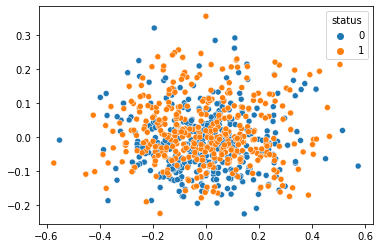

In [6]:
%matplotlib inline
pca = PCA(n_components=4)
pcs = pca.fit_transform(X)
sns.scatterplot(pcs[:, 0], pcs[:, 1], hue=y)

In [7]:
# Attempting to predict loop status using the sequence embedding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
pl = Pipeline([
    ('select', SelectKBest(f_classif)),
    ('scale', StandardScaler()),
    ('svc', SVC())]
)
# Search for optimal parameters (uses 5-fold cv for validation by default)
params = {
    'select__k': [2, 5, 10, 20, 'all'],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['linear', 'rbf'],
}
gs = GridSearchCV(pl, param_grid=params, verbose=True, n_jobs=12)
gs.fit(X, y)
print(
    f"Obtained a best accuracy of {gs.best_score_:.2f} "
    f"with the following parameters: \n{yaml.dump(gs.best_params_)}"
)
pl.set_params(**gs.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Obtained a best accuracy of 0.59 with the following parameters: 
select__k: 2
svc__gamma: scale
svc__kernel: rbf



Pipeline(steps=[('select', SelectKBest(k=2)), ('scale', StandardScaler()),
                ('svc', SVC())])

In [8]:
# Rerunning with best params using LOO validation
loo = LeaveOneOut()
correct = 0
preds = []
pl.set_params(**gs.best_params_)
for train_idx, test_idx in tqdm.tqdm(loo.split(X), unit='sample', total=X.shape[0]):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    pl.fit(X_train, y_train)
    preds.append(pl.predict(X_test))

100%|██████████| 776/776 [00:20<00:00, 37.49sample/s]


In [9]:
print(f"LOO accuracy: {accuracy_score(y, preds):.2f}")

LOO accuracy: 0.59


The averaged sequence embedding is not a good predictor of the looping status. Still, it is worth noting the results are slightly better than with the pretrained (on human, with k=3:8) dna2vec embedding.